In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!mkdir data
!gdown https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
!mv UTKFace.tar.gz data

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
100% 107M/107M [00:00<00:00, 129MB/s]


In [3]:
import tarfile
import os
import glob
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np

def load_file_names():
  # check if data has been extracted
  # if not, then extract the data
  if (os.path.isdir("./data/UTKFace")):
    print("Dataset already extracted")
  else:
    tar = tarfile.open("./data/UTKFace.tar.gz")
    tar.extractall("./data")
    tar.close()

  # Get list of all files in the dataset
  files = glob.glob("./data/UTKFace/*.jpg")
  labels = [int(f_name.split("/")[-1].split("_")[0]) for f_name in files]
  return files, labels

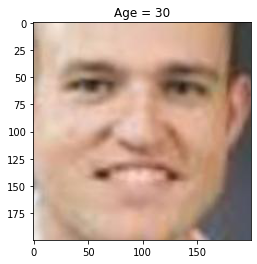

In [4]:
files, labels = load_file_names()
img = plt.imread(files[0])
plt.imshow(img)
plt.title(f"Age = {labels[0]}")
plt.show()

In [5]:
class Model(k.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.conv0 = k.layers.Conv2D(filters=8, kernel_size=5, strides=4, activation="relu")
    self.conv1 = k.layers.Conv2D(filters=16, kernel_size=5, strides=4, activation="relu")
    self.flatten = k.layers.Flatten()
    self.dropout = k.layers.Dropout(rate=0.2)
    self.dense0 = k.layers.Dense(units=128, activation="relu")
    self.dense1 = k.layers.Dense(units=64, activation="relu")
    self.dense2 = k.layers.Dense(units=1)
  
  def call(self, inputs, training=False):
    output = self.conv0(inputs)
    output = self.conv1(output)
    output = self.flatten(output)
    output = self.dropout(output, training)
    output = self.dense0(output)
    output = self.dense1(output)
    output = self.dense2(output)
    return output

In [6]:
# Hyperparameter definition

N_epochs = 20
learning_rate = 0.001
batch_size = 64
N_training_examples = 20000
N_validation_examples = 4*batch_size

N_parallel_iterations = 4
N_prefetch = 8
N_shuffle_buffer = 20000

In [7]:
from tensorflow.python.ops.gen_dataset_ops import prefetch_dataset

def parse_func(filename, label):
  image_string = tf.io.read_file(filename) # Read the image
  image_decoded = tf.io.decode_jpeg(image_string) # Decode the image
  image = tf.image.per_image_standardization(image_decoded) # Normalize the image
  label = tf.expand_dims(tf.cast(label, tf.float32), axis=-1)
  return image, label

def build_dataset(files, labels, batch_size):
  # Create tf data set
  ds = tf.data.Dataset.from_tensor_slices((files, labels)) # Create data set of files and labels
  ds = ds.shuffle(N_shuffle_buffer) # Enable shuffling
  ds = ds.map(parse_func, N_parallel_iterations) # Apply parse_func
  ds = ds.batch(batch_size).repeat().prefetch(N_prefetch) # Batch and prefetch
  return ds

# Shuffle data and labels
train_ds = build_dataset(files[0:N_training_examples], labels[0:N_training_examples], batch_size)
validation_ds = build_dataset(files[N_training_examples:N_training_examples+N_validation_examples], labels[N_training_examples:N_training_examples+N_validation_examples], batch_size)
test_ds = build_dataset(files[N_training_examples+N_validation_examples:], labels[N_training_examples+N_validation_examples:], batch_size)

In [8]:
# Define loss function
def loss(y, y_pred):
  return tf.reduce_mean(tf.abs(y - y_pred)) # MAE between "y" and "y_pred"

# Define training step as a complete graph
@tf.function  # It is a decorated to tell Tensorflow to make the function in the form of a graph so it runs faster. 
def train_step(model, optimizer, x, y):
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    y_pred = model(x) # Predict with model on "x"
    loss_val = loss(y, y_pred) # Compute the loss with "y" and "y_pred"
  grads = tape.gradient(loss_val, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss_val

In [9]:
model = Model()
opt = tf.optimizers.RMSprop(learning_rate)
model.build((batch_size, 200, 200, 3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  608       
                                                                 
 conv2d_1 (Conv2D)           multiple                  3216      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  295040    
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  65    

In [10]:
# Run training
epoch = 0
train_loss = 0.0
train_iters = 0
for train_images, train_labels in train_ds:
  train_loss += train_step(model, opt, train_images, train_labels) # Perform a train step
  train_iters += 1
  if train_iters % (N_training_examples/batch_size)==0: # An epoch is completed
    epoch += 1
    val_loss = 0.0
    val_iters = 0
    for val_images, val_labels in validation_ds:
      y_pred = model(val_images) # Predict on validation images
      loss_val = loss(val_labels, y_pred) # Compute loss for validation
      val_loss += loss_val
      val_iters += 1
      if val_iters == int(N_validation_examples/batch_size):
        print("Epoch: {} Training loss: {:.5} Validation loss {:.5}".format(epoch, train_loss/train_iters, val_loss/val_iters))
        break
    train_loss = 0.0
    train_iters = 0
  if epoch == N_epochs:
    break

Epoch: 1 Training loss: 11.292 Validation loss 8.304
Epoch: 2 Training loss: 8.7707 Validation loss 10.257
Epoch: 3 Training loss: 7.8864 Validation loss 7.2901
Epoch: 4 Training loss: 7.2285 Validation loss 7.9506
Epoch: 5 Training loss: 6.6636 Validation loss 7.0933
Epoch: 6 Training loss: 6.1157 Validation loss 7.0077
Epoch: 7 Training loss: 5.6985 Validation loss 7.7336
Epoch: 8 Training loss: 5.2706 Validation loss 7.0481
Epoch: 9 Training loss: 4.9306 Validation loss 7.1328
Epoch: 10 Training loss: 4.6197 Validation loss 7.3959
Epoch: 11 Training loss: 4.3206 Validation loss 7.1655
Epoch: 12 Training loss: 4.069 Validation loss 7.2922
Epoch: 13 Training loss: 3.8819 Validation loss 7.9314
Epoch: 14 Training loss: 3.6748 Validation loss 7.7656
Epoch: 15 Training loss: 3.5101 Validation loss 7.2301
Epoch: 16 Training loss: 3.4056 Validation loss 7.6684
Epoch: 17 Training loss: 3.2749 Validation loss 7.2206
Epoch: 18 Training loss: 3.1926 Validation loss 7.3426
Epoch: 19 Training lo

In [11]:
# Test model
Num_test_batches = int((len(files)-N_validation_examples-N_validation_examples)/batch_size)
test_loss = 0.0
test_iters = 0
for test_images, test_labels in test_ds:
  y_pred = model(test_images) # Predict on test images
  test_loss += loss(test_labels, y_pred) # Compute test loss
  test_iters += 1
  if test_iters == Num_test_batches:
    print("Test loss: {:.5}".format(test_loss/test_iters))
    break

Test loss: 8.0173
